In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nltk
from nltk import wordpunct_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import string

import textblob as tb
from tqdm import tqdm

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

In [212]:
# 데이터 읽기

df = pd.read_csv('daum_title.csv', encoding='utf-8')
df.columns = ['title']

print(df.head())
print(len(df))

                                  title
0            "팔짱 낀 김정숙 여사 외교 결례"? 진실은..
1                     독이 된 황교안의 '가벼운 입'
2                  밀착 보좌' 현송월..지켜보는 김여정
3        합참 "중부전선 DMZ서 레이더에 정체불명 항적 포착"
4  '김영철 후임' 北장금철, 판문점회동 참석한 듯..남측에 '첫선'
300


In [213]:
df['title'].isnull().values.any()

False

In [214]:
# 5 데이터

df1 = df.loc[270:299]

In [215]:
# 한자 한국어로 매칭

def change_string(x):
    return x.replace('靑','청와대').replace('軍','군대').replace('北','북한').replace('美','미국').replace('日','일본').replace('韓', '한국').replace('與', '여당').replace('野', '야당').replace('中', '중국').replace('黃', '황교안').replace('文', '문재인')

In [216]:
df1['title'] = df1['title'].map(lambda x : change_string(x))

C:\Users\LeeJeungHun\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [217]:
news_title = [] # 리스트 선언
news_title.extend(list(df1.title.values)) # 헤드라인의 값들을 리스트로 저장
# news_title = [n for n in news_title if len(n) >=10]
len(news_title) # 제거 후 샘플의 개수

30

In [218]:
# 특수문자, 숫자 제거

from string import punctuation
import re

def clean_text(text):
#     cleaned_text = [''.join(c for c in text).lower()]
#     cleaned_text = re.sub('[^가-힣a-zA-Z文 ]', '', text)
    cleaned_text = re.sub('[0-9]', ' ', text)
    cleaned_text = re.sub('[\{\}\[\]\/?.,;:|\)*~`!^\-_+<>@\#$%&\\\=\(\'\"\'\·]',
                          ' ', cleaned_text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    return cleaned_text

In [219]:
text = [clean_text(x) for x in news_title]
text = pd.DataFrame(text, columns=['title'])
text.head()

,title
0,위증으로 역전된 윤석열 검증 한국 바른미래 공조 카드는
1,파묻었던 일제 만행 봉인 열릴까 두려운 아베
2,홍남기 반도체 몇개월치 완제품 재고 기업 걱정은 소재 부품
3,박지원 조국 법무장관 기용될 것 윤석열 임명돼야
4,홍준표 윤석열 변호사법 위반 논란에 단순 정보제공 별 문제 안 돼


In [220]:
from konlpy.tag import Komoran

stopwords = set(['신문', '종합', '단독', '상보', '속보', '것', '내일'])
dicpath = 'user_dict.txt' # 텍스트 파일주소로, 사용자 사전의 구조는 위와 같습니다.

komoran = Komoran(userdic=dicpath)
text['title'] = text.apply(lambda row: komoran.nouns(row['title']), axis=1)
text['title'] = text['title'].apply(lambda x: [word for word in x if word not in stopwords])
text.head()

,title
0,"[위증, 역전, 윤석열, 검증, 한국, 바른, 미래, 공조, 카드]"
1,"[일제, 만행, 봉인, 아베]"
2,"[홍, 남, 반도체, 개월, 완제품, 재고, 기업, 걱정, 소재, 부품]"
3,"[박지원, 조국, 법무장관, 기용, 윤석열, 임명]"
4,"[홍준표, 윤석열, 변호사법, 위반, 논란, 정보, 제공, 문제]"


In [221]:
# 한 글자 단어 제거

tokenized_doc = text['title'].apply(lambda x: [word for word in x if len(word) >1])
tokenized_doc.head()

0    [위증, 역전, 윤석열, 검증, 한국, 바른, 미래, 공조, 카드]
1                         [일제, 만행, 봉인, 아베]
2       [반도체, 개월, 완제품, 재고, 기업, 걱정, 소재, 부품]
3             [박지원, 조국, 법무장관, 기용, 윤석열, 임명]
4     [홍준표, 윤석열, 변호사법, 위반, 논란, 정보, 제공, 문제]
Name: title, dtype: object

In [222]:
# 역 토큰화

documents = []
for i in range(len(text)):
    t = ' '.join(tokenized_doc[i])
    documents.append(t)
    
documents[:5]

['위증 역전 윤석열 검증 한국 바른 미래 공조 카드',
 '일제 만행 봉인 아베',
 '반도체 개월 완제품 재고 기업 걱정 소재 부품',
 '박지원 조국 법무장관 기용 윤석열 임명',
 '홍준표 윤석열 변호사법 위반 논란 정보 제공 문제']

In [223]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [224]:
id2word = corpora.Dictionary(tokenized_doc)

texts = tokenized_doc

corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]]


In [225]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('검증', 1),
  ('공조', 1),
  ('미래', 1),
  ('바른', 1),
  ('역전', 1),
  ('위증', 1),
  ('윤석열', 1),
  ('카드', 1),
  ('한국', 1)]]

In [226]:
import os
from gensim.models.wrappers import LdaMallet

# os.environ['MALLET_HOME'] = 'C:\\Users\\camel\\mallet-2.0.8'
os.environ['MALLET_HOME'] = 'C:/Users\LeeJeungHun/Desktop/데이터_프로젝트/drive-download-20190826T021000Z-001/mallet-2.0.8'

# mallet_path = 'C:/Users/camel/mallet-2.0.8/bin/mallet'
mallet_path = 'C:/Users/LeeJeungHun/Desktop/데이터_프로젝트/drive-download-20190826T021000Z-001/mallet-2.0.8/bin/mallet'

In [227]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [228]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=tokenized_doc, start=1, limit=16, step=3)

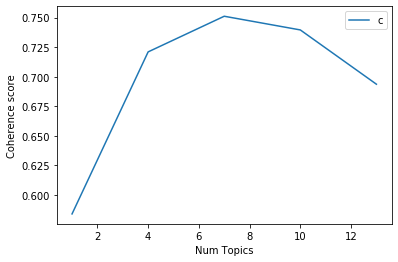

In [229]:
# Show graph
limit = 16; start=1; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel('Num Topics')
plt.ylabel('Coherence score')
plt.legend(('coherence_values'), loc='best')
plt.show()

In [230]:
for m, cv in zip(x, coherence_values):
    print('Num Topics =', m, " has Coherence Value of", round(cv, 4))

Num Topics = 1  has Coherence Value of 0.584
Num Topics = 4  has Coherence Value of 0.721
Num Topics = 7  has Coherence Value of 0.7511
Num Topics = 10  has Coherence Value of 0.7395
Num Topics = 13  has Coherence Value of 0.6937


In [231]:
# # Select the model and print the topics
# optimal_model = model_list[3]
# model_topics = optimal_model.show_topics(formatted=False)
# pprint(optimal_model.print_topics(num_words=10))

In [177]:
# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=7, id2word=id2word)

# import gensim    
# mallet_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

In [178]:
# # Visualize the topics
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(mallet_model, corpus, id2word)
# vis

In [232]:
# Build LDA model
#num_topics를 바꿔줘야함 그래프의 최대값 시작에 따라
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=7,
                                           alpha='auto',
                                           per_word_topics=True)

In [233]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.045*"일본" + 0.028*"반도체" + 0.028*"소재" + 0.028*"한국" + 0.019*"윤석열" + '
  '0.019*"완제품" + 0.019*"재고" + 0.019*"개월" + 0.019*"기업" + 0.019*"부품"'),
 (1,
  '0.049*"윤석열" + 0.038*"임명" + 0.026*"논란" + 0.026*"아베" + 0.026*"만행" + '
  '0.026*"봉인" + 0.026*"일제" + 0.015*"위증" + 0.015*"홍준표" + 0.015*"비상"'),
 (2,
  '0.043*"일본" + 0.030*"한국" + 0.017*"수출규제" + 0.017*"생각" + 0.017*"문재인대통령" + '
  '0.017*"허심탄회" + 0.017*"반대" + 0.017*"이야기" + 0.017*"사린" + 0.017*"우려"'),
 (3,
  '0.044*"문재인대통령" + 0.030*"수출규제" + 0.030*"일본" + 0.017*"대응" + 0.017*"위반" + '
  '0.017*"대기업" + 0.017*"비상" + 0.017*"외교" + 0.017*"생각" + 0.017*"기업인"')]


In [234]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_doc, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -5.427914769033303

Coherence Score:  0.407516606744426


In [235]:
# Visualize the topics
#p = pyLDAvis.gensim.prepare(topic_model, corpus, dictionary)
#pyLDAvis.save_html(p, 'lda_2.html').enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\LeeJeungHun\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.095681  0.090135       1        1  38.441547
1      0.135541  0.042586       2        1  24.111885
2     -0.029902 -0.076735       3        1  18.938070
3     -0.009958 -0.055986       4        1  18.508490, topic_info=    Category      Freq    Term     Total  loglift  logprob
24   Default  2.000000      임명  2.000000  30.0000  30.0000
63   Default  3.000000  문재인대통령  3.000000  29.0000  29.0000
50   Default  6.000000      일본  6.000000  28.0000  28.0000
6    Default  4.000000     윤석열  4.000000  27.0000  27.0000
8    Default  3.000000      한국  3.000000  26.0000  26.0000
43   Default  2.000000    수출규제  2.000000  25.0000  25.0000
26   Default  1.000000      논란  1.000000  24.0000  24.0000
11   Default  1.000000      아베  1.000000  23.0000  23.0000
9    Default  1.000000      만행  1.000000  22.0000  22.0000
10   Default  1.000000      봉인  1.000000  2

blahblah

In [236]:
pyLDAvis.save_html(vis, 'daum_title_10.html')